In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import ast
from sklearn.preprocessing import MinMaxScaler

# Universal device selection for both Mac (MPS) and NVIDIA (CUDA) GPUs
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA GPU: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Metal Performance Shaders) on Mac GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

print(f"Device: {device}")

Using MPS (Metal Performance Shaders) on Mac GPU
Device: mps


In [2]:
def load_data(from_cache:bool = True, csv_path:str = 'labeled_dataset.csv', dataset_root:str = './2025_Dataset') -> any:
    """
    Loads dataset from either a cached CSV file or by scanning the raw dataset directory.

    This function supports two modes:
    - If `from_cache` is True, it loads the dataset from a pre-saved CSV file.
    - If `from_cache` is False, it scans the '2025_Dataset' directory for image and depth data,
      parses the folder names to extract pitch and roll values, and saves the processed data
      into a CSV file for future use.

    The dataset is expected to be organized in folders following the naming convention:
    `P<pitch>_R<roll>`, where each folder contains a depth file named `<folder_name>_depth.txt`.
    Each line in the depth file is expected to be a tuple string of the form:
    `('filename.jpg', depth_value)`.

    Parameters:
    -----------
    from_cache : bool, optional
        If True, loads data from the CSV file specified by `csv_path`. 
        If False, scans the '2025_Dataset' directory and saves data to `csv_path`.
        Default is True.

    csv_path : str, optional
        Path to the CSV file for caching or loading data. Default is 'labeled_dataset.csv'.
        
    dataset_root : str, optional
        Path to the dataset folder. Default is '2025_Dataset'.

    Returns:
    --------
    pandas.DataFrame or None
        If `from_cache` is True, returns a DataFrame loaded from the CSV file.
        If `from_cache` is False, returns the DataFrame after processing and saving to CSV,
        and also prints summary statistics.

    Raises:
    -------
    FileNotFoundError
        If the '2025_Dataset' directory is not found.

    Notes:
    ------
    - The function assumes the notebook is run from the 'Course Work' directory.
    - When `from_cache` is False, the function saves the processed data to a CSV file
      and prints information about total images processed and sample rows.
    """
    if from_cache == False:
        # Define the root directory of the dataset relative to the notebook
        data = []

        # Check if dataset directory exists
        if not os.path.exists(dataset_root):
            print(f"Error: Dataset directory '{dataset_root}' not found. Please ensure you are running this notebook from the 'Course Work' directory.")
        else:
            print(f"Scanning dataset in '{dataset_root}'...")
            
            # Walk through the dataset directory
            for folder_name in sorted(os.listdir(dataset_root)):
                folder_path = os.path.join(dataset_root, folder_name)
                
                # Check if it's a directory and follows the Px_Ry pattern
                if os.path.isdir(folder_path) and folder_name.startswith('P') and '_R' in folder_name:
                    try:
                        # Parse Pitch and Roll from folder name (e.g., P0_R0 -> Pitch=0, Roll=0)
                        parts = folder_name.split('_')
                        pitch = int(parts[0][1:]) # Remove 'P'
                        roll = int(parts[1][1:])  # Remove 'R'
                        
                        # Find the depth file (e.g., P0_R0_depth.txt)
                        depth_files = [f for f in os.listdir(folder_path) if f.endswith('_depth.txt')]
                        
                        if depth_files:
                            depth_file_path = os.path.join(folder_path, depth_files[0])
                            
                            with open(depth_file_path, 'r') as f:
                                for line in f:
                                    # The line format is "('filename.jpg', depth_value)"
                                    line = line.strip()
                                    if not line: continue
                                    
                                    try:
                                        # Safely parse the tuple string
                                        img_name, depth_val = ast.literal_eval(line)
                                        
                                        # Construct relative path
                                        # Note: The DataFrame will store the path relative to the notebook/dataset root
                                        rel_path = os.path.join(dataset_root, folder_name, img_name)
                                        
                                        data.append({
                                            'relative_path': rel_path,
                                            'image_name': img_name,
                                            'pitch': pitch,
                                            'roll': roll,
                                            'depth': depth_val
                                        })
                                    except Exception as e:
                                        print(f"Error parsing line in {depth_files[0]}: {line} - {e}")
                    except Exception as e:
                        print(f"Error processing folder {folder_name}: {e}")
            # Create DataFrame
            df = pd.DataFrame(data)

            # Save to CSV
            df.to_csv(csv_path, index=False)
            return df
    else:
        return pd.read_csv(csv_path)

    print(f"Dataset processing complete. Saved to {csv_path}")
    print(f"Total images processed: {len(df)}")
    print(df.head())

df = load_data(from_cache=False)
df.head()

Scanning dataset in './2025_Dataset'...


,relative_path,image_name,pitch,roll,depth
0,./2025_Dataset/P0_R0/video_14_stable_bot_l6s3_...,video_14_stable_bot_l6s3_P0_R0_00219.jpg,0,0,0.785
1,./2025_Dataset/P0_R0/video_14_stable_bot_l6s3_...,video_14_stable_bot_l6s3_P0_R0_00222.jpg,0,0,0.686
2,./2025_Dataset/P0_R0/video_14_stable_bot_l6s3_...,video_14_stable_bot_l6s3_P0_R0_00228.jpg,0,0,0.991
3,./2025_Dataset/P0_R0/video_14_stable_bot_l6s3_...,video_14_stable_bot_l6s3_P0_R0_00120.jpg,0,0,0.103
4,./2025_Dataset/P0_R0/video_14_stable_bot_l6s3_...,video_14_stable_bot_l6s3_P0_R0_00198.jpg,0,0,0.931


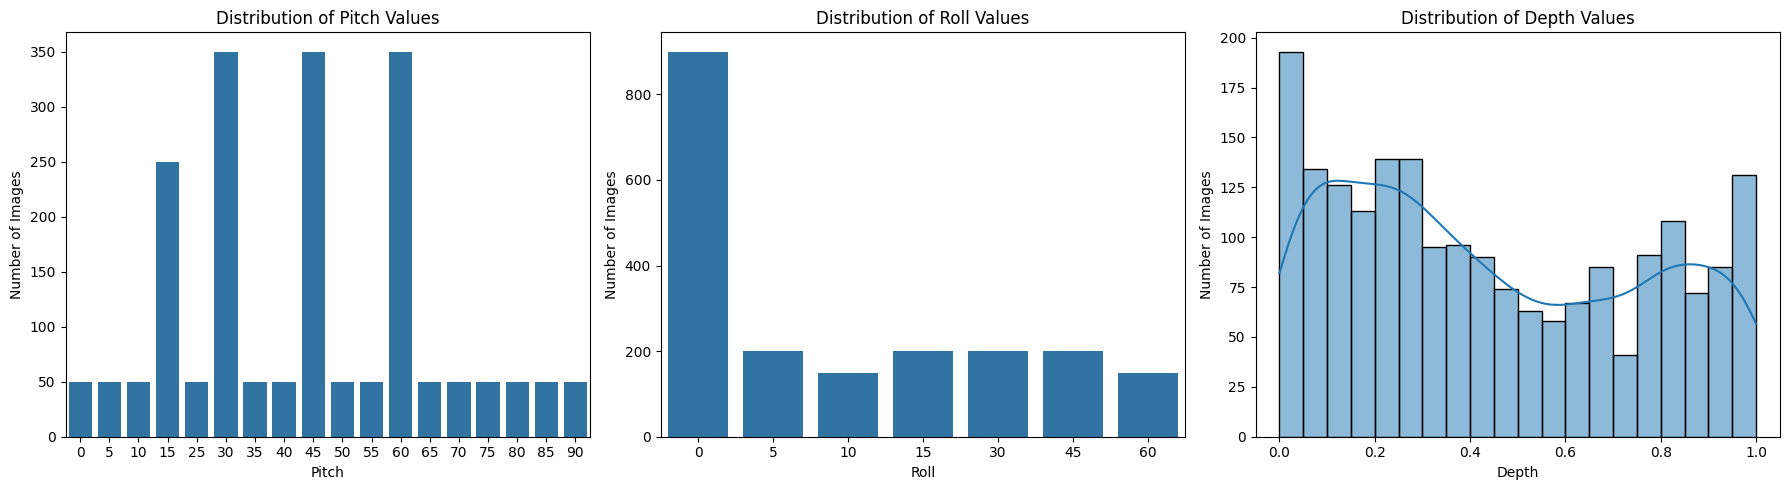

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# show 3 images
for i, col in enumerate(['pitch', 'roll']):
    sns.countplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f'Distribution of {col.capitalize()} Values')
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel('Number of Images')

# depth separately
sns.histplot(data=df, x='depth', bins=20, kde=True, ax=axes[2])
axes[2].set_title('Distribution of Depth Values')
axes[2].set_xlabel('Depth')
axes[2].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

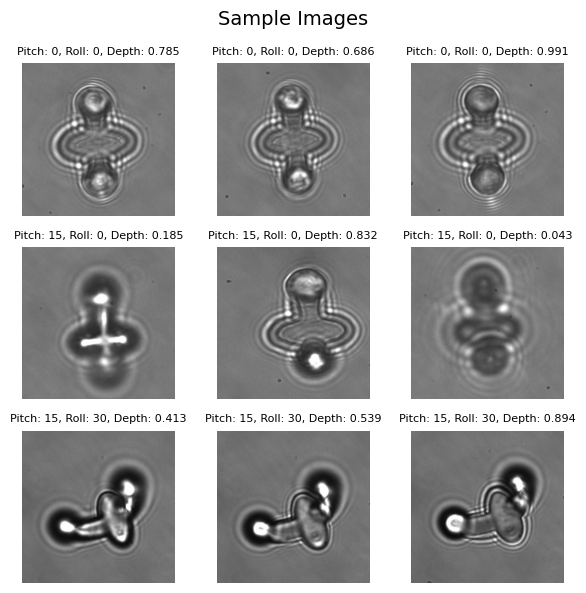

In [59]:
width, height = 3, 3
jump = 35

fig, axes = plt.subplots(height, width, figsize=(width*2, height*2))
fig.suptitle('Sample Images', fontsize=14)

for i in range(height):
    for j in range(width):
        img_path = df.iloc[i*width*jump + j]['relative_path']
        img = plt.imread(img_path)
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"Pitch: {df.iloc[i*width*jump + j]['pitch']}, Roll: {df.iloc[i*width*jump + j]['roll']}, Depth: {df.iloc[i*width*jump + j]['depth']}", fontsize=8)
        axes[i, j].axis('off')  

plt.tight_layout()
plt.show()


In [ ]:
# from skimage import exposure

def normalize_image(img, method='minmax'):
    """
    Normalize image pixel intensities using various methods.
    ---------
    Simple: scales by dividing by 225

    Min-Max: scales pixel values to [0, 1] based on min and max of the image.

    Standard: standardizes pixel values to have zero mean and unit variance, then clips to [-3, 3] and scales to [0, 1].
    """
    
    if method == 'simple':  # Simple does not visibly change anything about the image.
                            # Sticking to this for now but will see if others improve performance.
        # Simple normalization to [0, 1] 
        return img / 255.0
    
    elif method == 'minmax':
        # Min-Max normalization per image (stretches contrast)
        img_min = img.min()
        img_max = img.max()
        if img_max - img_min == 0:
            return img / 255.0
        return (img - img_min) / (img_max - img_min)
    
    elif method == 'standard':
        # Standardization (zero mean, unit variance)
        mean = img.mean()
        std = img.std()
        if std == 0:
            return img / 255.0
        normalized = (img - mean) / std
        # Clip to reasonable range and scale to [0, 1]
        normalized = np.clip(normalized, -3, 3)
        return (normalized + 3) / 6
    
    
    else:
        return img / 255.0



In [ ]:
# # Reset norm folder
# import glob
# import os

# files = glob.glob('./2025_Dataset_norm/**/norm_*', recursive=True)
# for f in files:
#     os.remove(f)
# print(f"Deleted {len(files)} files starting with 'norm_'")


Deleted 2691 files starting with 'norm_'


In [100]:
# create a new dataset for normalized images
normalized_data = []
for index, row in df.iterrows():
    img_path = row['relative_path']
    img = plt.imread(img_path)
    normalized_img = normalize_image(img, method='simple')
    
    # Save normalized image to a new path in the 2025_Dataset_norm folder
    norm_img_name = f"norm_{row['image_name']}"
    norm_img_path = os.path.join('./2025_Dataset_norm', norm_img_name)
    plt.imsave(norm_img_path, normalized_img)
    
    normalized_data.append({
        'relative_path': norm_img_path,
        'image_name': norm_img_name,
        'pitch': row['pitch'],
        'roll': row['roll'],
        'depth': row['depth']
    })

In [101]:
# turn the normalised data into a df
normalized_df = pd.DataFrame(normalized_data)
normalized_df.head()

# Minmax the depth values
scaler = MinMaxScaler()
normalized_df['minmax_depth'] = scaler.fit_transform(normalized_df[['depth']])
normalized_df.head()

,relative_path,image_name,pitch,roll,depth,minmax_depth
0,./2025_Dataset_norm/norm_video_14_stable_bot_l...,norm_video_14_stable_bot_l6s3_P0_R0_00219.jpg,0,0,0.785,0.785
1,./2025_Dataset_norm/norm_video_14_stable_bot_l...,norm_video_14_stable_bot_l6s3_P0_R0_00222.jpg,0,0,0.686,0.686
2,./2025_Dataset_norm/norm_video_14_stable_bot_l...,norm_video_14_stable_bot_l6s3_P0_R0_00228.jpg,0,0,0.991,0.991
3,./2025_Dataset_norm/norm_video_14_stable_bot_l...,norm_video_14_stable_bot_l6s3_P0_R0_00120.jpg,0,0,0.103,0.103
4,./2025_Dataset_norm/norm_video_14_stable_bot_l...,norm_video_14_stable_bot_l6s3_P0_R0_00198.jpg,0,0,0.931,0.931


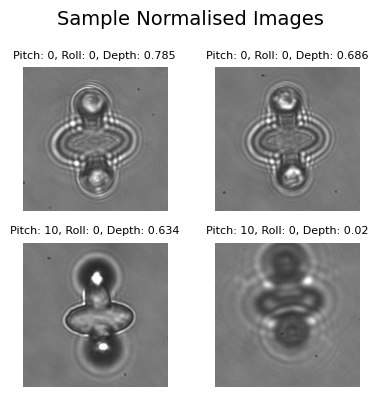

In [104]:
width, height = 2, 2
jump = 35

fig, axes = plt.subplots(height, width, figsize=(width*2, height*2))
fig.suptitle('Sample Normalised Images', fontsize=14)

for i in range(height):
    for j in range(width):
        img_path = normalized_df.iloc[i*width*jump + j]['relative_path']
        img = plt.imread(img_path)
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"Pitch: {normalized_df.iloc[i*width*jump + j]['pitch']}, Roll: {normalized_df.iloc[i*width*jump + j]['roll']}, Depth: {normalized_df.iloc[i*width*jump + j]['depth']}", fontsize=8)
        axes[i, j].axis('off')  

plt.tight_layout()
plt.show()

# # Non-normalised images for comparison
# fig, axes = plt.subplots(height, width, figsize=(width*2, height*2))
# fig.suptitle('Sample Images', fontsize=14)

# for i in range(height):
#     for j in range(width):
#         img_path = df.iloc[i*width*jump + j]['relative_path']
#         img = plt.imread(img_path)
#         axes[i, j].imshow(img)
#         axes[i, j].set_title(f"Pitch: {df.iloc[i*width*jump + j]['pitch']}, Roll: {df.iloc[i*width*jump + j]['roll']}, Depth: {df.iloc[i*width*jump + j]['depth']}", fontsize=8)
#         axes[i, j].axis('off')  

# plt.tight_layout()
# plt.show()

# Data split

In [ ]:
# split data into 60 20 20 with stratification on


from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(normalized_df, test_size=0.4, stratify=normalized_df[['pitch', 'roll']], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df[['pitch', 'roll']], random_state=42)
# Data split

